In [8]:
%matplotlib inline
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
# from google.colab import files
# %config InlineBackend.figure_format = 'svg'

In [9]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [10]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [11]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-2, -1))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-2, -1))
        
    def forward(self, x, sample = True):
        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

In [12]:
class BBP_Homoscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise):
        super(BBP_Homoscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, no_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(no_units, output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([init_log_noise]))

    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

In [13]:

class BBP_Homoscedastic_Model_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, init_log_noise):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = BBP_Homoscedastic_Model(input_dim = input_dim, output_dim = output_dim,
                                               no_units = no_units, init_log_noise = init_log_noise)
        self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr = self.learn_rate) 
        # self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss_total = fit_loss_total + self.loss_func(output, y, self.network.log_noise.exp(), self.network.output_dim)
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total

In [14]:
np.random.seed(2)
no_points = 100
x = np.random.uniform(0, 0.5, no_points)[:, None]
x.sort(axis = 0)

e = np.random.normal(0, 0.02, no_points).reshape((no_points, 1))
y = x + 0.3 * np.sin(2 * np.pi * (x + e)) + 0.3 * np.sin(4 * np.pi * (x + e)) + e

y = (y - y.mean())
x_train = x #[75:325]
y_train = y #[75:325]

x_mean, x_std = x_train.mean(), x_train.var()**0.5
y_mean, y_std = y_train.mean(), y_train.var()**0.5

x_train = (x_train - x_mean)/x_std
y_train = (y_train - y_mean)/y_std


num_epochs, batch_size, nb_train = 5000, len(x_train), len(x_train)

net = BBP_Homoscedastic_Model_Wrapper(input_dim = 1, output_dim = 1, no_units = 100, learn_rate = 1e-1,
                                      batch_size = batch_size, no_batches = 1, init_log_noise = 0)

fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
total_loss = np.zeros(num_epochs)

best_net, best_loss = None, float('inf')

for i in range(num_epochs):
    
    fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 10)
    fit_loss_train[i] += fit_loss.cpu().data.numpy()
    KL_loss_train[i] += KL_loss.cpu().data.numpy()
    
    total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
    
    if fit_loss < best_loss:
        best_loss = fit_loss
        best_net = copy.deepcopy(net.network)
        
    if i % 100 == 0 or i == num_epochs - 1:
        
        print("Epoch: %5d/%5d, Fit loss = %8.3f, KL loss = %8.3f, noise = %6.3f" %
              (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i], net.network.log_noise.exp().cpu().data.numpy()))

        samples = []
        for i in range(100):
            preds = net.network.forward(torch.linspace(0, 0.5, 200).cuda())[0]
            samples.append(preds.cpu().data.numpy()[:, 0])


Epoch:     1/ 5000, Fit loss =   60.137, KL loss =  344.480, noise =  1.020
Epoch:   101/ 5000, Fit loss =   52.172, KL loss =  345.286, noise =  1.000
Epoch:   201/ 5000, Fit loss =   38.240, KL loss =  346.471, noise =  0.909
Epoch:   301/ 5000, Fit loss =   36.779, KL loss =  347.612, noise =  0.881
Epoch:   401/ 5000, Fit loss =   26.960, KL loss =  349.059, noise =  0.833
Epoch:   501/ 5000, Fit loss =   24.075, KL loss =  351.616, noise =  0.772
Epoch:   601/ 5000, Fit loss =   19.766, KL loss =  354.941, noise =  0.726
Epoch:   701/ 5000, Fit loss =   17.699, KL loss =  358.189, noise =  0.705
Epoch:   801/ 5000, Fit loss =   15.070, KL loss =  361.169, noise =  0.684
Epoch:   901/ 5000, Fit loss =   16.300, KL loss =  363.787, noise =  0.664
Epoch:  1001/ 5000, Fit loss =    3.712, KL loss =  365.934, noise =  0.636
Epoch:  1101/ 5000, Fit loss =    8.078, KL loss =  368.097, noise =  0.627
Epoch:  1201/ 5000, Fit loss =   -8.810, KL loss =  370.299, noise =  0.582
Epoch:  1301

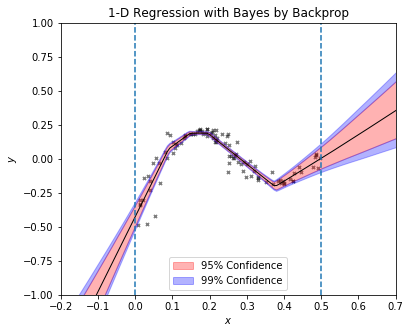

In [22]:
samples = []
for i in range(100):
    preds = (best_net.forward(torch.linspace(-5, 5, 200).cuda())[0] * y_std) + y_mean
    samples.append(preds.cpu().data.numpy()[:, 0])

samples = np.array(samples)
means = samples.mean(axis = 0)

var = samples.var(axis = 0)**0.5


plt.figure(figsize = (6, 5))
plt.scatter((x_train * x_std) + x_mean, (y_train * y_std) + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means - 1.96*var, means + 1.96*var, color = 'red', alpha = 0.3, label = '95% Confidence')

plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means - 2.58*var, means - 1.96*var, color = 'blue', alpha = 0.3, label = '99% Confidence')
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means + 1.96*var, means + 2.58*var, color = 'blue', alpha = 0.3)



plt.plot(np.linspace(-5, 5, 200)*x_std + x_mean, means, color = 'black', linewidth = 1)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim((-0.2, 0.7))
plt.title('1-D Regression with Bayes by Backprop')
plt.tick_params()
plt.legend()
plt.ylim((-1,1))
plt.axvline(x=0, linestyle='--')
plt.axvline(x=0.5, linestyle='--')
# plt.savefig('bbp_homo.pdf', bbox_inches = 'tight')

plt.show()

# Dropout

In [23]:

class MC_Dropout_Layer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob):
        super(MC_Dropout_Layer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout_prob = dropout_prob
        
        self.weights = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.biases = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        
    def forward(self, x):
        
        dropout_mask = torch.bernoulli((1 - self.dropout_prob)*torch.ones(self.weights.shape)).cuda()
        
        return torch.mm(x, self.weights*dropout_mask) + self.biases

In [24]:
class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise):
        super(MC_Dropout_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.layer1 = nn.Linear(input_dim, no_units)
        self.layer2 = nn.Linear(no_units, output_dim)
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([init_log_noise]))

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=0.5, training=True)
        
        x = self.layer2(x)
        
        return x

In [25]:
class MC_Dropout_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, weight_decay, init_log_noise):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = MC_Dropout_Model(input_dim = input_dim, output_dim = output_dim,
                                        no_units = no_units, init_log_noise = init_log_noise)
        self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output, y, torch.exp(self.network.log_noise), 1)/len(x)
        
        loss.backward()
        self.optimizer.step()

        return loss

In [26]:
np.random.seed(2)
no_points = 100
lengthscale = 1
x = np.random.uniform(0, 0.5, no_points)[:, None]
x.sort(axis = 0)



e = np.random.normal(0, 0.02, no_points).reshape((no_points, 1))
y = x + 0.3 * np.sin(2 * np.pi * (x + e)) + 0.3 * np.sin(4 * np.pi * (x + e)) + e

# print(x, y, x.shape, y.shape, e.shape)
y = (y - y.mean())
x_train = x #[75:325]
y_train = y #[75:325]

x_mean, x_std = x_train.mean(), x_train.var()**0.5
y_mean, y_std = y_train.mean(), y_train.var()**0.5

x_train = (x_train - x_mean)/x_std
y_train = (y_train - y_mean)/y_std


num_epochs, batch_size, nb_train = 5000, len(x_train), len(x_train)

net = MC_Dropout_Wrapper(input_dim = 1, output_dim=1, no_units=200, learn_rate=1e-2,
                         batch_size=batch_size, no_batches=1, init_log_noise=0, weight_decay=1e-2)

for i in range(num_epochs):
    
    loss = net.fit(x_train, y_train)
    
    if i % 200 == 0:
        print('Epoch: %4d, Train loss = %7.3f, noise = %6.3f' % \
              (i, loss.cpu().data.numpy(), torch.exp(net.network.log_noise).cpu().data.numpy()))

Epoch:    0, Train loss =   0.548, noise =  1.001
Epoch:  200, Train loss =   0.067, noise =  0.692
Epoch:  400, Train loss =  -0.113, noise =  0.589
Epoch:  600, Train loss =  -0.169, noise =  0.555
Epoch:  800, Train loss =  -0.200, noise =  0.547
Epoch: 1000, Train loss =  -0.122, noise =  0.525
Epoch: 1200, Train loss =  -0.223, noise =  0.530
Epoch: 1400, Train loss =  -0.270, noise =  0.525
Epoch: 1600, Train loss =  -0.204, noise =  0.521
Epoch: 1800, Train loss =  -0.203, noise =  0.514
Epoch: 2000, Train loss =  -0.160, noise =  0.511
Epoch: 2200, Train loss =  -0.170, noise =  0.512
Epoch: 2400, Train loss =  -0.251, noise =  0.502
Epoch: 2600, Train loss =  -0.240, noise =  0.502
Epoch: 2800, Train loss =  -0.129, noise =  0.505
Epoch: 3000, Train loss =  -0.175, noise =  0.498
Epoch: 3200, Train loss =  -0.224, noise =  0.508
Epoch: 3400, Train loss =  -0.241, noise =  0.503
Epoch: 3600, Train loss =  -0.279, noise =  0.499
Epoch: 3800, Train loss =  -0.194, noise =  0.498


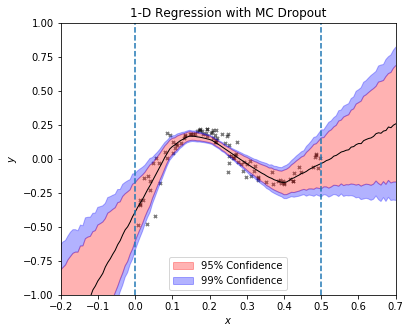

In [27]:
samples = []
noises = []
for i in range(1000):
    preds = net.network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
    samples.append(preds)
    
samples = np.array(samples)
means = (samples.mean(axis = 0)).reshape(-1)

var = (samples.var(axis = 0)**0.5).reshape(-1) * y_std


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
# plt.style.use('default')
plt.scatter((x_train * x_std) + x_mean, (y_train * y_std) + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means*y_std - 1.96*var, means*y_std + 1.96*var, color = 'red', alpha = 0.3, label = '95% Confidence')

plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means*y_std - 2.58*var, means*y_std - 1.96*var, color = 'blue', alpha = 0.3, label = '99% Confidence')
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means*y_std + 1.96*var, means*y_std + 2.58*var, color = 'blue', alpha = 0.3)



plt.plot(np.linspace(-5, 5, 200)*x_std + x_mean, means*y_std, color = 'black', linewidth = 1)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim((-0.2, 0.7))
plt.title('1-D Regression with MC Dropout')
plt.tick_params()
plt.legend()
plt.ylim((-1,1))
plt.axvline(x=0, linestyle='--')
plt.axvline(x=0.5, linestyle='--')
# plt.savefig('dropout_homo.pdf', bbox_inches = 'tight')

plt.show()